In [25]:
import numpy as np         
import pandas as pd        
import scipy  # модуль для работы со статистикой
from scipy import stats
import statsmodels
# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')    # стиль графиков
%matplotlib inline
%run f2forecast.py

<Figure size 432x288 with 0 Axes>

In [276]:
data_df = pd.read_excel(r'../data/file.xlsx')

Text(0, 0.5, 'продажи')

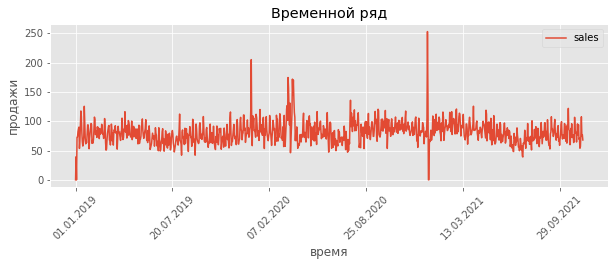

In [279]:
first_df = data_df.copy()
first_df.set_index('ds', inplace=True)
first_df.plot()
plt.title("Временной ряд")
plt.xlabel("время")
plt.tick_params(axis ='x', rotation = 45)
plt.ylabel("продажи")

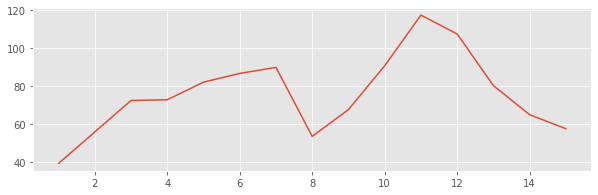

In [200]:
mean = np.mean(data_df.sales) # выборочное среднее
sigma = np.std(data_df.sales)
data_df = data_df[(data_df.sales > mean - 3*sigma) & (data_df.sales < mean + 3*sigma)]
sales = data_df.sales
dates = data_df.index
plt.plot(dates[:14], sales[:14])

Усредняем по неделям

In [207]:
data_df['ds'] = pd.to_datetime(data_df['ds'])
week_df = data_df.groupby([pd.Grouper(key='ds', freq='W-MON')])['sales'].mean().reset_index().sort_values('ds')
week_df = week_df.dropna()

Text(0, 0.5, 'продажи')

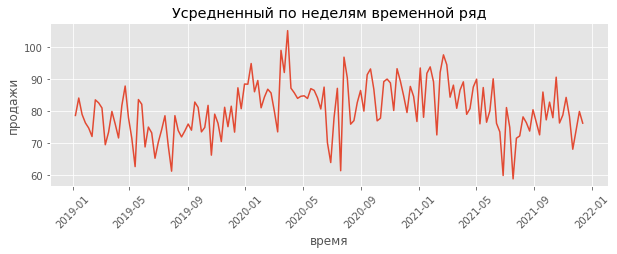

In [203]:
plt.plot(week_df.ds, week_df.sales)
plt.title("Усредненный по неделям временной ряд")
plt.xlabel("время")
plt.tick_params(axis ='x', rotation = 45)
plt.ylabel("продажи")

Проверка на стационарность
1) ACF - автокорреляционная функция 

In [98]:
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

In [84]:
salesW = week_df['sales']

In [ ]:
pd.plotting.autocorrelation_plot(salesW)

2

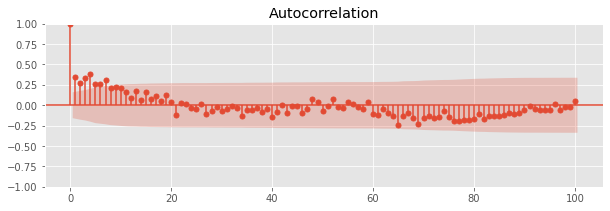

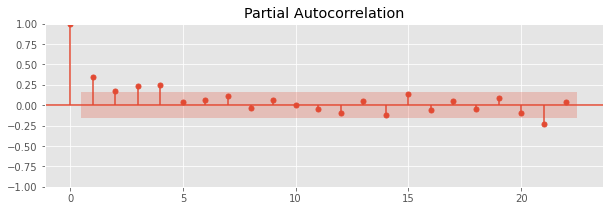

In [280]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(week_df.sales, lags=100)
plot_pacf(week_df.sales)

Тесты на стационарность

In [270]:
test = sm.tsa.adfuller(week_df.sales)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print( 'есть единичные корни, ряд не стационарен')
else:
    print( 'единичных корней нет, ряд стационарен')

adf:  -2.9687289697984425
p-value:  0.037919724244280736
Critical values:  {'1%': -3.4750180242954167, '5%': -2.8811408028842043, '10%': -2.577221358046935}
единичных корней нет, ряд стационарен


2

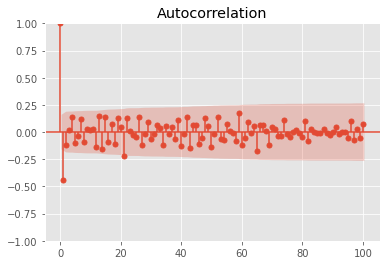

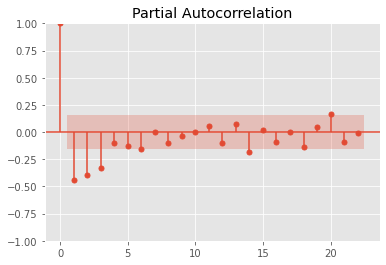

In [110]:
week_sales_stat = week_df.sales.diff(periods=1).dropna()
plot_acf(week_sales_stat, lags=100)
plot_pacf(week_sales_stat)
1+1

In [112]:
week_df.sales.describe()

count    153.000000
mean      80.526314
std        8.250464
min       58.640000
25%       75.031429
50%       80.351429
75%       86.791429
max      105.190000
Name: sales, dtype: float64

count - число наблюдений, которое есть без пропусков
mean - среднее значение
std - стандартное отклонение
min - минимум
max - максимум
50% - медиана (половина выборки больше неё, половина меньше)
25% - 25% квантиль (четверть выборки меньше, 75% больше)
75% - 75% квантиль

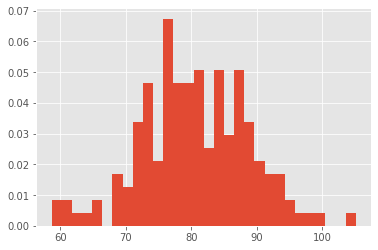

In [117]:
plt.hist(week_df.sales, bins=30,  density=True)
x = np.linspace(0, 100, 100)

Декомпозиция на основе тренда и сезонности

Text(0.5, 0.98, 'Аддитивная модель')

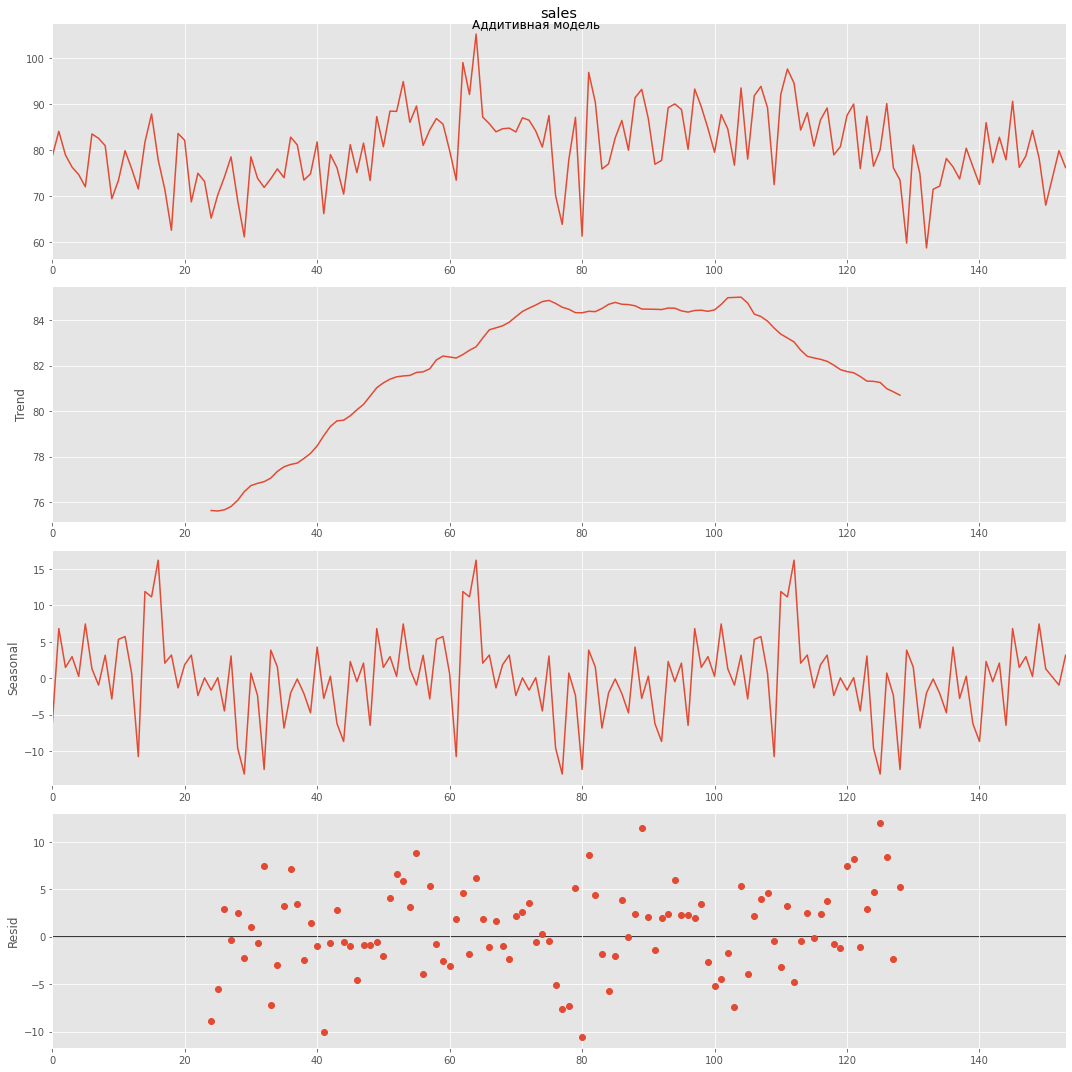

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose
#data_df = validate_series(data_df)
result_M = seasonal_decompose(week_df.sales, model='additive', period=48)

plt.rcParams.update({'figure.figsize': (15,15)})
result_M.plot().suptitle('Аддитивная модель')

Text(0.5, 0.98, 'Мультипликативная модель')

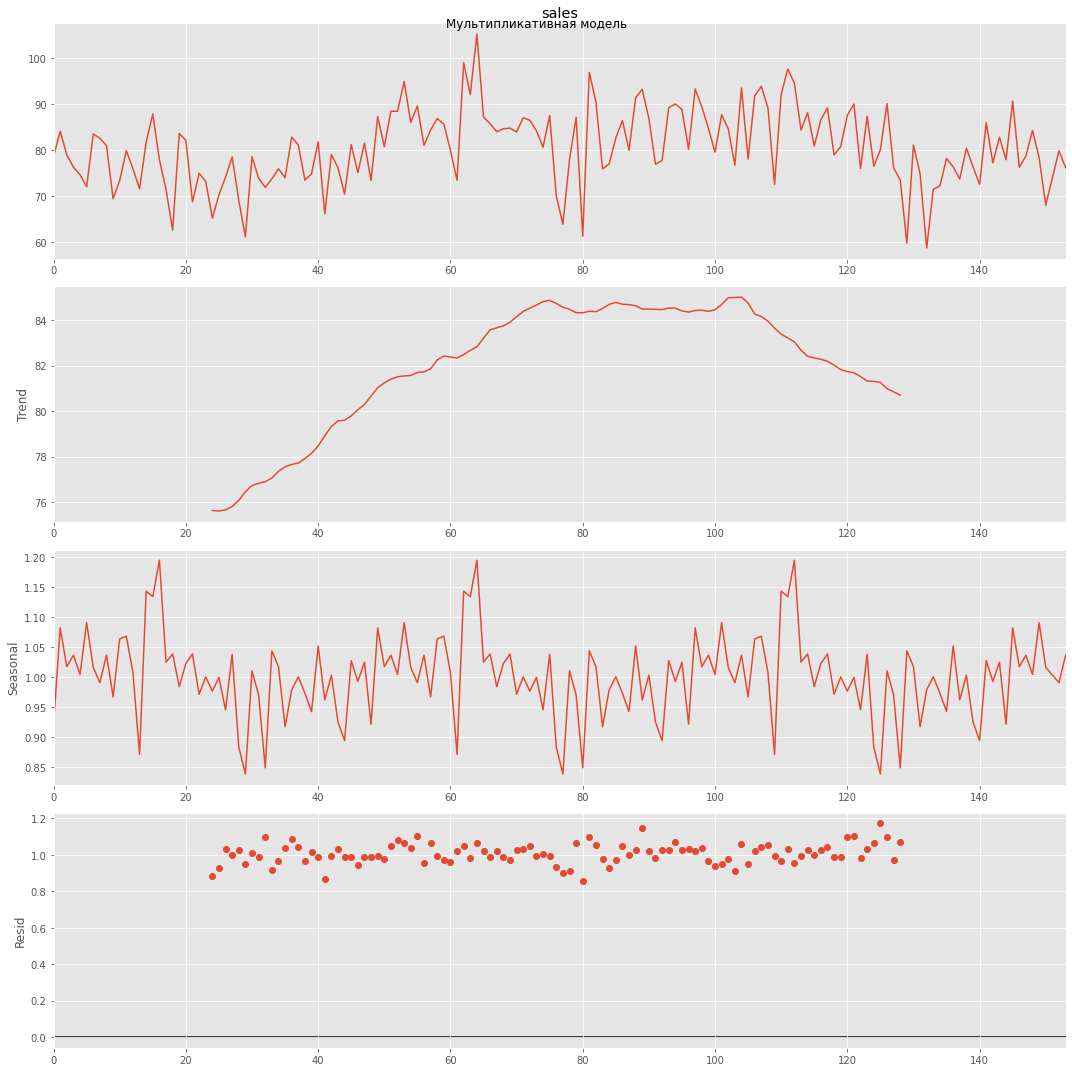

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose
from adtk.data import validate_series
# data_df_temp = data_df[(data_df.sales <100 ) & (data_df.sales != 0)]
# data_df_temp = validate_series(data_df_temp)
result_M = seasonal_decompose(week_df.sales, model='multiplicative', period=48)

plt.rcParams.update({'figure.figsize': (15,15)})
result_M.plot().suptitle('Мультипликативная модель')

In [209]:
train_df=week_df[(week_df.ds > '2018') & (week_df.ds <'2021')]
train_df.set_index('ds', inplace=True)
train = train_df.sales

In [256]:
test_df=week_df[(week_df.ds >='2021')]
test_df.set_index('ds', inplace=True)
test = test_df.sales

SARIMA

График автокорреляции

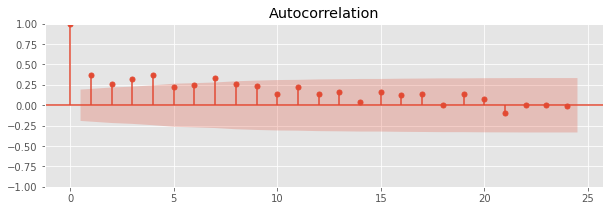

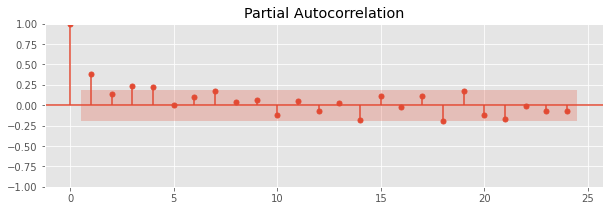

In [165]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train, lags=24)
plot_pacf(train, lags=24)
plt.show()

Подбор параметров модели

In [ ]:
model = auto_arima(train, seasonal=True, m=48, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

In [283]:
mod = sm.tsa.statespace.SARIMAX(train_df, order=(1, 0, 1),seasonal_order=(1, 0, 0,48))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.002    491.238      0.000       0.996       1.004
ma.L1         -0.8116      0.052    -15.756      0.000      -0.913      -0.711
ar.S.L48       0.2168      0.155      1.397      0.163      -0.087       0.521
sigma2        50.6004      6.896      7.337      0.000      37.084      64.117


Построим диагностические графики для полученной модели

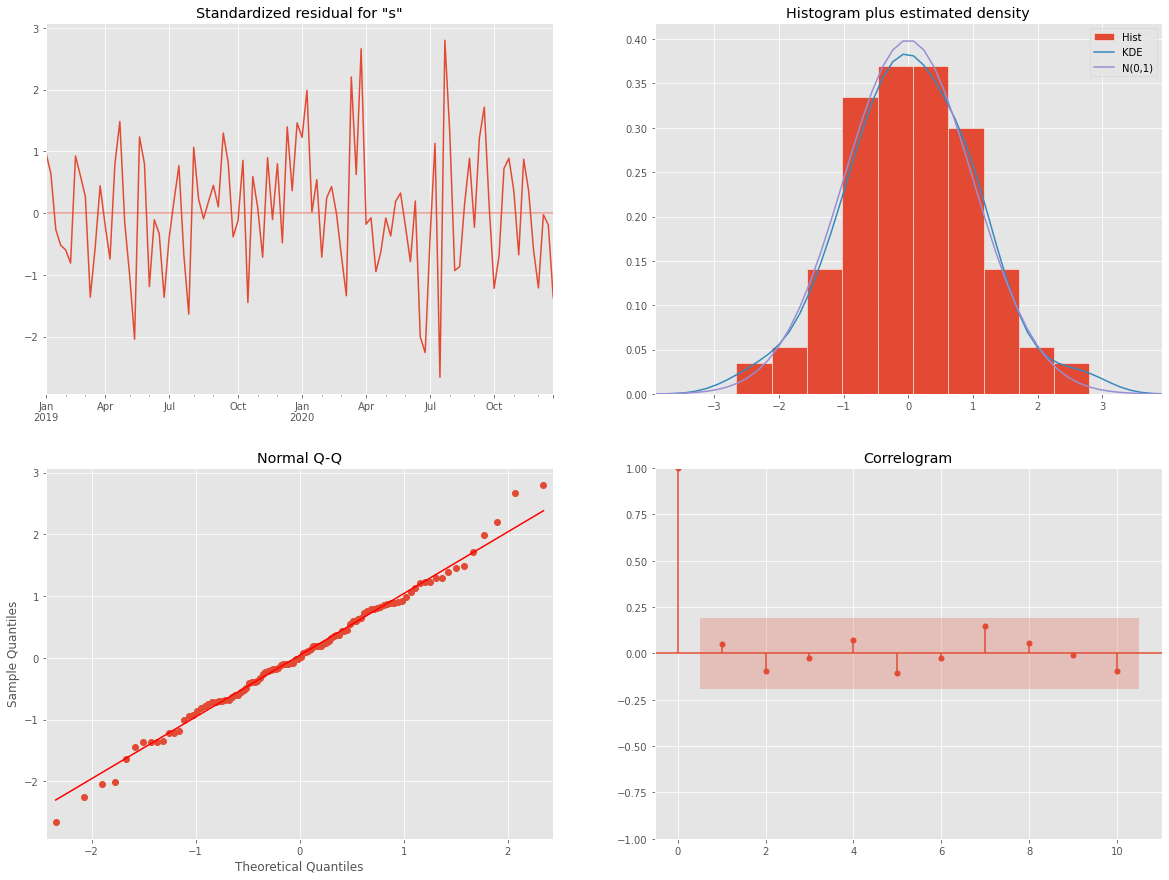

In [284]:
results.plot_diagnostics(figsize=(20, 15))
plt.show()

Оценим точность нашей модели по стандартным метрикам.

In [294]:
predict=results.get_prediction(start='2019-01-14')
metrics(train['2019-01-14':], predict.predicted_mean)

Тест на стационарность:
	T-статистика = -9.481
	P-значение = 0.000
Критические значения :
	1%: -3.4961490537199116 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8903209639580556 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5821223452518263 - Данные  стационарны с вероятностью 90% процентов
MAD: 5.6433
MSE: 51.6623
MAPE: 0.0714
MPE: -0.0046
Стандартная ошибка: 7.1876


Сделаем прогноз на год вперед и построим график.

In [286]:
predict=results.get_prediction(start='2021', end='2022')

In [287]:
total_df = week_df.copy()
total_df.set_index('ds', inplace=True)

In [217]:
print(results.fittedvalues)

ds
2019-01-07     0.000000
2019-01-14    78.556614
2019-01-21    81.349320
2019-01-28    80.470909
2019-02-04    79.259915
                ...    
2020-11-30    88.972524
2020-12-07    88.155795
2020-12-14    87.919227
2020-12-21    85.965565
2020-12-28    86.456813
Length: 104, dtype: float64


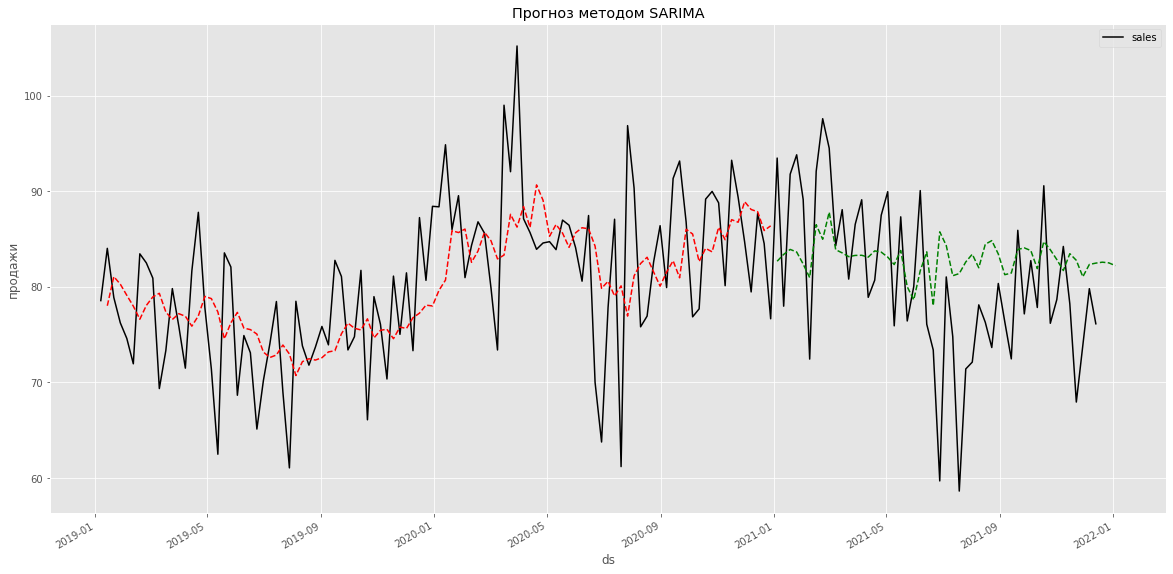

In [289]:
ax = total_df.plot(figsize=(20,10), color='black', title="Прогноз методом SARIMA" )
plt.xlabel("время")
plt.ylabel("продажи")
results.fittedvalues['2019-01-14':].plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()


Оценим модель на точность по тестовым данным

In [235]:
print(test_df)

                sales
ds                   
2021-01-04  93.467500
2021-01-11  77.977143
2021-01-18  91.778333
2021-01-25  93.808571
2021-02-01  89.130000
2021-02-08  72.442857
2021-02-15  92.075000
2021-02-22  97.584286
2021-03-01  94.502857
2021-03-08  84.295714
2021-03-15  88.070000
2021-03-22  80.808571
2021-03-29  86.535714
2021-04-05  89.108571
2021-04-12  78.903333
2021-04-19  80.695714
2021-04-26  87.491429
2021-05-03  89.952857
2021-05-10  75.921429
2021-05-17  87.321667
2021-05-24  76.430000
2021-05-31  80.025714
2021-06-07  90.065714
2021-06-14  76.088333
2021-06-21  73.394286
2021-06-28  59.700000
2021-07-05  81.035714
2021-07-12  74.790000
2021-07-19  58.640000
2021-07-26  71.412857
2021-08-02  72.127143
2021-08-09  78.114286
2021-08-16  76.295000
2021-08-23  73.654286
2021-08-30  80.351429
2021-09-06  76.342857
2021-09-13  72.465000
2021-09-20  85.911429
2021-09-27  77.170000
2021-10-04  82.741429
2021-10-11  77.840000
2021-10-18  90.571667
2021-10-25  76.187143
2021-11-01